<a href="https://colab.research.google.com/github/seismosmsr/machine_learning/blob/main/LandCover_UNET_apply.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-z1drnueg
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-z1drnueg
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=7deac5bcd8d5c92c1a60471a02134b2450064455992889c074828279953f74e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-w1ine4aj/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [4]:
!pip install rasterio scikit-image tensorflow keras gdown 
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 71.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.4 MB/s eta 0:00:00


In [5]:
import urllib.request

url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"  # Replace with the URL of the file you want to download
save_path = '/content/sam_vit_h_4b8939.pth'  # Replace with the desired path and file name to save

urllib.request.urlretrieve(url, save_path)

('/content/sam_vit_h_4b8939.pth', <http.client.HTTPMessage at 0x7f98f34df4c0>)

In [6]:
# Required libraries
import rasterio
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
import os
import glob
import os
import gdown
import zipfile
import rasterio
from skimage.transform import resize
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import random
from keras.utils import to_categorical
from skimage.util import random_noise
import rasterio
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
import os
import glob
import numpy as np
from scipy import ndimage
from scipy.ndimage import label
import cv2
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import rasterio
import rasterio.plot
import numpy as np
import cv2
from scipy.ndimage import generic_filter


In [7]:
# Download the dataset
url = 'https://drive.google.com/uc?id=1f4eGmykyiczmNz2VPeNNmQ7aC7q8N_hD'
output = '/content/california_land_use.zip'
gdown.download(url, output, quiet=False)

# Extract the dataset
cwd = os.getcwd()
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(cwd+'/sample_data')


Downloading...
From: https://drive.google.com/uc?id=1f4eGmykyiczmNz2VPeNNmQ7aC7q8N_hD
To: /content/california_land_use.zip
100%|██████████| 2.76G/2.76G [00:25<00:00, 109MB/s]


In [8]:
# Loading data from geotiff files
def load_data(directory):
    data = []
    files = glob.glob(os.path.join(directory, "*.tif"))
    for file in files:
        with rasterio.open(file) as src:
            band_data = []
            for band in src.read():
                band_data.append(band)
            data.append(np.dstack(band_data))
    
    return np.array(data)

In [9]:
def load_and_reshape_image(image_path, img_height, img_width):
    with rasterio.open(image_path) as src:
        # Read the image data
        image = src.read()
        # Reshape the image
        image = image.transpose((1, 2, 0))
        # Resize image if necessary
        if image.shape[0] != img_height or image.shape[1] != img_width:
            image = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_NEAREST)
        # Ensure labels do not have an extra channel dimension
        if len(image.shape) == 3 and image.shape[2] == 1:
            image = np.squeeze(image, axis=2)
        return image

In [10]:
def load_images_and_labels(image_files, label_files, img_height, img_width, num_classes):
  images = []
  labels = []

  image_files = glob.glob(os.path.join(image_files, "*.tif"))
  for image_file in image_files:
      image = load_and_reshape_image(image_file, img_height, img_width)
      images.append(image)

  label_files = glob.glob(os.path.join(label_files, "*.tif"))
  for label_file in label_files:
      label = load_and_reshape_image(label_file, img_height, img_width)
      label -= 1  # adjust labels to be in the range 0-8 instead of 1-9
      label = to_categorical(label, num_classes=9)   # one-hot encode the labels
      labels.append(label)

  return np.array(images), np.array(labels)



In [11]:
import glob
import os
import cv2
import numpy as np
import rasterio
from keras.utils import Sequence, to_categorical

class DataGenerator(Sequence):
    def __init__(self, image_folder, label_folder, img_height, img_width, batch_size, num_classes, noise):
        self.image_files = glob.glob(os.path.join(image_folder, "*.tif"))
        self.label_files = glob.glob(os.path.join(label_folder, "*.tif"))
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.noise = noise

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.image_files[index * self.batch_size : (index + 1) * self.batch_size]
        batch_images, batch_labels = self.load_images_and_labels(batch_files)
        return batch_images, batch_labels

    def load_and_reshape_image(self, image_path):
        with rasterio.open(image_path) as src:
            image = src.read()
            image = image.transpose((1, 2, 0))
            if image.shape[0] != self.img_height or image.shape[1] != self.img_width:
                image = cv2.resize(image, (self.img_width, self.img_height), interpolation=cv2.INTER_NEAREST)
            if len(image.shape) == 3 and image.shape[2] == 1:
                image = np.squeeze(image, axis=2)
            if self.noise:
                variance = np.var(image)
                image = image*random_noise(image, mode='gaussian', var=variance)
            return image

    def load_images_and_labels(self, image_files):
        images = []
        labels = []

        for image_file in image_files:
            image = self.load_and_reshape_image(image_file)
            images.append(image)

        for image_file in image_files:
            label_file = image_file.replace("rgbNIR", "labels")
            label = self.load_and_reshape_image(label_file)
            label -= 1
            label = to_categorical(label, num_classes=self.num_classes)
            labels.append(label)

        return np.array(images), np.array(labels)


In [12]:
def create_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size)  # Change the number of channels to 4

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])  # Use sparse categorical cross-entropy loss
    return model


In [13]:
def predict_and_save(input_folder, output_folder, model, img_height, img_width):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Get a list of input files
    input_files = [f for f in os.listdir(input_folder) if f.endswith('.tif')]

    for filename in input_files:
        # Read input image
        input_path = os.path.join(input_folder, filename)
        with rasterio.open(input_path) as src:
            # Read image data and reshape
            image = src.read()  # Read all bands
            image = np.transpose(image, (1, 2, 0))  # Transpose to (height, width, bands)
            image = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_NEAREST)
            image = np.expand_dims(image, axis=0)  # Add batch dimension

            # Perform prediction
            prediction = model.predict(image)

        # Get metadata from the input image
        meta = src.meta

        # Update metadata for the output image
        meta.update(count=10, dtype=prediction.dtype)

        # Create output path
        output_path = os.path.join(output_folder, filename)

        # Write all 9 prediction channels as separate bands
        with rasterio.open(output_path, 'w', **meta) as dst:
            for i in range(9):
                dst.write(prediction[0, :, :, i], i + 1)  # Write each channel as a separate band

            # Add a 10th band containing the argmax of the 9 channels
            argmax_band = np.argmax(prediction[0], axis=-1)
            dst.write(argmax_band, 10)

        print(f"Saved prediction for {filename}")

    print("Prediction and saving completed.")

In [14]:
import numpy as np
from scipy import ndimage
from scipy.ndimage import label as nd_label

def process_pred(pred):

    def modal_filter(arr):
      modes, counts = np.unique(arr, return_counts=True)
      max_count_idx = np.argmax(counts)
      return modes[max_count_idx]
      
    pred = pred.astype(np.uint8)
    # Converting input to 16 bit and replacing '0' values with 'nan'
    pred = np.where(pred.astype(np.uint16) == 0, np.nan, pred)

    # Create a mask of valid (non-NA) cells
    valid_mask = ~np.isnan(pred)

    # Compute the distance to the nearest valid cell for each cell
    dist = ndimage.distance_transform_edt(~valid_mask, return_distances=False, return_indices=True)

    # Assign the value of the nearest valid cell to each cell
    pred_filled = pred[tuple(dist)]

    # Create a mask for NA values after filling
    na_mask = np.isnan(pred_filled)

    # Create 2D structure for labeling
    structure = np.ones((3, 3), dtype=bool)

    # Label each separate cluster of NA values
    labeled_mask, num_labels = nd_label(na_mask, structure=structure)

    # Assign new values to each separate cluster
    for label_num in range(1, num_labels + 1):
        pred_filled[labeled_mask == label_num] = np.nanmax(pred_filled) + label_num

    # Convert filled prediction to 8-bit
    pred_filled = pred_filled.astype(np.uint8)

    # Perform morphological opening operation to clean up small segments
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    cleaned_pred = cv2.morphologyEx(pred_filled, cv2.MORPH_OPEN, kernel)

    # Apply modal filter using a sliding window approach
    modal_filtered = np.zeros_like(cleaned_pred)
    for i in range(1, cleaned_pred.shape[0] - 1):
        for j in range(1, cleaned_pred.shape[1] - 1):
            neighborhood = cleaned_pred[i-1:i+2, j-1:j+2]
            modal_filtered[i, j] = modal_filter(neighborhood)

    return modal_filtered

In [15]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for i, ann in enumerate(sorted_anns):
        m = ann['segmentation']
        # color_mask = np.concatenate([np.random.random(3), [0.35]])
        color_mask = i
        img[m] = color_mask

    return img

In [16]:
def assign_class_by_probability(pred, probability):
    num_classes = probability.shape[-1]

    # Create an array to store the assigned classes for each clump
    assigned_classes = np.zeros_like(pred, dtype=np.uint8)

    # Assign class based on mean probability for each clump
    unique_labels = np.unique(pred)
    for label in unique_labels:
        if label != 0:
            clump_mask = pred == label
            clump_probabilities = probability[clump_mask]
            clump_mean_probabilities = np.mean(clump_probabilities, axis=0)
            assigned_class = np.argmax(clump_mean_probabilities) + 1
            assigned_classes[pred == label] = assigned_class

    return assigned_classes

In [17]:
# model = create_model(img_size = (640,640,3),num_classes =9)

In [18]:
training_image_folder = "/content/sample_data/training/rgbNIR"  # Replace with your image folder path
training_label_folder = "/content/sample_data/training/labels"  # Replace with your label folder path

validation_image_folder = "/content/sample_data/validation/rgbNIR"  # Replace with your image folder path
validation_label_folder = "/content/sample_data/validation/labels"  # Replace with your label folder path


img_height = 640  # Set your desired image height
img_width = 640  # Set your desired image width
batch_size = 16  # Set your desired batch size
num_classes = 9  # Set the number of classes for one-hot encoding

# Create the data generator
training_data_generator = DataGenerator(training_image_folder, training_label_folder, img_height, img_width, batch_size, num_classes,True)
validation_data_generator = DataGenerator(validation_image_folder, validation_label_folder, img_height, img_width, batch_size, num_classes,False)


In [19]:
from keras.models import load_model

# Load the model from memory
model = load_model('/content/drive/MyDrive/Colab_Demo/landcover_model.h5')

In [20]:
# Train the model
# model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=50)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
# history = model.fit(training_data_generator, validation_data=validation_data_generator, epochs=1)

# Evaluate the model
# loss, accuracy = model.evaluate(validation_data_generator)
# print("Validation Loss:", loss)
# print("Validation Accuracy:", accuracy)

# model.fit(training_generator, validation_data=validation_generator, epochs=100)

In [21]:
device = "cuda"
sam = sam_model_registry["vit_h"](checkpoint= '/content/sam_vit_h_4b8939.pth' )
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [22]:
mask_generator = SamAutomaticMaskGenerator(model=sam,
                                           points_per_side=32,
                                           pred_iou_thresh=0.8,
                                           stability_score_thresh=0.8,
                                           crop_n_layers=1,
                                           crop_n_points_downscale_factor=2,
                                           min_mask_region_area=200,  # Requires open-cv to run post-processing
                                           )

In [23]:
from scipy.stats import mode

In [33]:
# image = batch_images[index]
# image

1/1 [==============================] - 0s 58ms/step


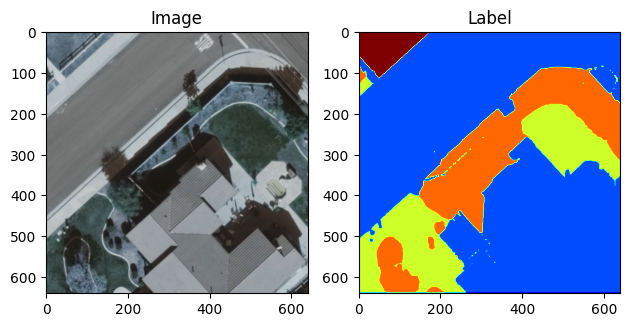

In [31]:
import matplotlib.pyplot as plt

# Get a batch of data from the generator
batch_images, batch_labels = validation_data_generator[4]

# Run predictions on the sample
predictions = model.predict(batch_images)

# Select a random index from the batch
index = np.random.randint(0, batch_images.shape[0])

# Retrieve the image and label at the selected index
image = batch_images[index]
label = predictions[index]

# image = load_and_reshape_image(image_path,640, 640)
# image = image*255
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
masks = mask_generator.generate(image)

flat_mask = show_anns(masks)
# imagery_file = rasterio.open(image_path)
# imagery_transform = imagery_file.transform
reshaped_image = rasterio.plot.reshape_as_raster(flat_mask)

reshaped_image[3] = process_pred(reshaped_image[3])
label = assign_class_by_probability(reshaped_image[3],predictions[index])

# Rescale the image to the range [0, 1]
# image = image.astype(np.float32) / 255.0

# Plot the image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Image")

# Plot the label
plt.subplot(1, 2, 2)
plt.imshow(label, cmap='jet')
plt.title("Label")

plt.tight_layout()
plt.show()


In [25]:
# image_path = "/content/sample_data/training/rgbNIR/1760_5920.tif"
# image

In [26]:
reshaped_image_filled[3]

NameError: ignored

In [ ]:
reshaped_image_filled = reshaped_image
# reshaped_image_filled[3] = process_pred(reshaped_image_filled[3])
reshaped_image_filled[3] = assign_class_by_probability(reshaped_image_filled[3],predictions[index])
# reshaped_image_filled[3] = classify_clumps(reshaped_image_filled[3],predictions)
reshaped_image_filled = reshaped_image_filled.astype(np.uint8)
output_raster = rasterio.open(f"/content/mask_example.tif",
                              'w',
                              driver='GTiff',
                              height=reshaped_image_filled.shape[1], width=reshaped_image_filled.shape[2],
                              count=reshaped_image_filled.shape[0], dtype=str(rasterio.uint8),
                              crs='EPSG:4326',
                              transform=imagery_transform)
for band in range(reshaped_image_filled.shape[0]):
    output_raster.write(reshaped_image_filled[band], band + 1)
output_raster.close()

In [ ]:
# raster = 
assign_class_by_probability(reshaped_image_filled[3],predictions[index])
# raster
# labeled_mask, num_labels = label(reshaped_image_filled[3])
# raster = np.argmax(predictions,0)
# plt.imshow(raster, cmap='viridis')
# plt.colorbar()
# plt.show()

In [ ]:
reshaped_image_filled[3]

In [ ]:
import numpy as np

def assign_class_by_probability(pred, probability):
    num_classes = probability.shape[-1]

    # Create an array to store the assigned classes for each clump
    assigned_classes = np.zeros_like(pred, dtype=np.uint8)

    # Assign class based on mean probability for each clump
    unique_labels = np.unique(pred)
    for label in unique_labels:
        if label != 0:
            clump_mask = np.expand_dims(pred == label, axis=-1)
            clump_probabilities = probability * clump_mask
            clump_mean_probabilities = np.mean(clump_probabilities, axis=(0, 1))
            assigned_class = np.argmax(clump_mean_probabilities)
            assigned_classes[pred == label] = assigned_class + 1

    return assigned_classes


In [ ]:
# np.mean(predictions, axis=(0, 1))

In [ ]:
clump_mask = reshaped_image_filled[3] == 26

In [ ]:

def assign_class_by_probability(pred, probability):
    num_classes = probability.shape[-1]

    # Create an array to store the assigned classes for each clump
    assigned_classes = np.zeros_like(pred, dtype=np.uint8)

    # Calculate the mean probabilities for each clump
    clump_mean_probabilities = np.mean(probability, axis=(0, 1))

    # Assign class based on mean probability for each clump
    unique_labels = np.unique(pred)
    for i, label in enumerate(unique_labels):
        if label != 0:
            clump_mask = pred == label
            assigned_classes[clump_mask] = i + 1

    return assigned_classes
